### CLUSTERING BUSINESS
#### cluster time trends in NYC businesses:
#### DATA
#### Census Business data:

In [2]:
import os 
import pandas as pd
import zipfile 
import glob
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
import seaborn
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
import geopandas as gp
import numpy as np
import seaborn

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
path = os.getenv("PUIDATA") + '/Census Business data'
os.chdir(path)
zbpfile = glob.glob("*.zip")

In [4]:
fi = []
for fname in zbpfile:
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df['Year'] = fname[3:5]
    fi.append(df)
    
zbpfile = pd.concat(fi)

In [5]:
zbpfile.Year.unique()

array(['99', '98', '97', '96', '95', '94', '14', '13', '12', '11', '10',
       '09', '08', '07', '06', '05', '04', '03', '02', '01', '00'], dtype=object)

In [6]:
zbpfile.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,0.0,0.0,B,2.0,"HOLTSVILLE, NY",0.0,99,501.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,252624.0,7786.0,NaN,469.0,"AGAWAM, MA",58129.0,99,1001.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,163105.0,6607.0,NaN,558.0,"AMHERST, MA",36220.0,99,1002.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1646.0,82.0,NaN,13.0,"AMHERST, MA",336.0,99,1003.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10426.0,600.0,NaN,35.0,"AMHERST, MA",2659.0,99,1004.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### NYC zip codes shape file:

In [7]:
zipcode = gp.read_file(os.getenv("PUIDATA") + '/nyc-zip-code-tabulation-areas-polygons.geojson')

In [8]:
zipcode.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


#### Prep the data.

In [9]:
zbpfile = zbpfile[zbpfile['ZIP'].isin(zipcode["postalCode"].astype(float)) |\
                 zbpfile['zip'].isin(zipcode["postalCode"].astype(float))]

In [10]:
zbp = pd.concat([zbpfile[["EST", "ZIP", "Year"]].dropna().rename(columns={"EST":"est", "ZIP":"zip"}), 
                      zbpfile[["est", "zip", "Year"]].dropna()])

In [11]:
zbp.Year.unique()

array(['99', '98', '02', '01', '00', '97', '96', '95', '94', '14', '13',
       '12', '11', '10', '09', '08', '07', '06', '05', '04', '03'], dtype=object)

In [12]:
zbp.shape

(5014, 3)

In [13]:
zbp.Year = pd.to_datetime(zbp.Year, format="%y").dt.year

In [14]:
zbp.head()

,est,zip,Year
3000,7233.0,10001.0,1999
3001,2085.0,10002.0,1999
3002,3659.0,10003.0,1999
3003,1233.0,10004.0,1999
3004,1242.0,10005.0,1999


In [15]:
zbp = zbp.pivot(index="zip", columns="Year", values="est")

In [16]:
zbp.head()

Year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005.0,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [17]:
zbp_stardard = zbp.apply(lambda x: (x - x.mean())/x.std(), axis=1)

In [18]:
zbp_stardard.shape

(244, 21)

In [19]:
zbp_stardard.fillna(0, inplace = True)

#### Cluster

In [20]:
nc = 5
km = KMeans(n_clusters = nc)
km.fit(zbp_stardard)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### Plot

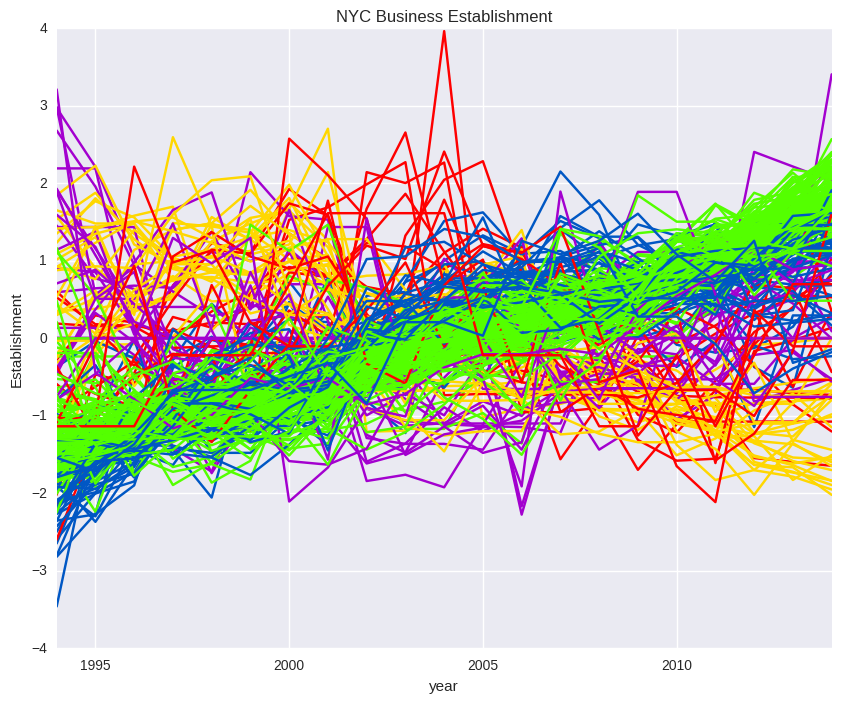

In [21]:
cmap = plt.cm.prism(np.linspace(0,1,5))
plt.figure(figsize=(10,8))
plt.xlim(1994,2014)
for i in range(len(zbp_stardard)):
    c = km.labels_[i]
    plt.plot(range(1994,2015), zbp_stardard.iloc[i,:21], color = cmap[c][:3])
plt.ylabel("Establishment")
plt.xlabel("year")
plt.title("NYC Business Establishment")

In [22]:
Z = linkage(zbp_stardard.iloc[:,:21].values, 'ward')

In [23]:
plt.figure(figsize=(20, 500))
plt.title('Hierarchical Clustering Dendrogram', fontsize=50)
dendrogram(
    Z,
    color_threshold=np.inf,
    orientation="left",
    labels = zbp_stardard.iloc[:,:21].index.values,
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [25]:
AC = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(zbp_stardard.iloc[:,:21])

In [27]:
KMdf = pd.DataFrame({"zip":zbp_stardard.index.values, "label":km.labels_})
ACdf = pd.DataFrame({"zip":zbp_stardard.index.values, "label":AC.labels_})

In [28]:
zipcode.rename(columns={"postalCode":"zip"}, inplace = True)
zipcode["zip"] = pd.to_numeric(zipcode["zip"])

In [30]:
zipzbp = zipcode.merge(KMdf, on = "zip").merge(ACdf, on = "zip")

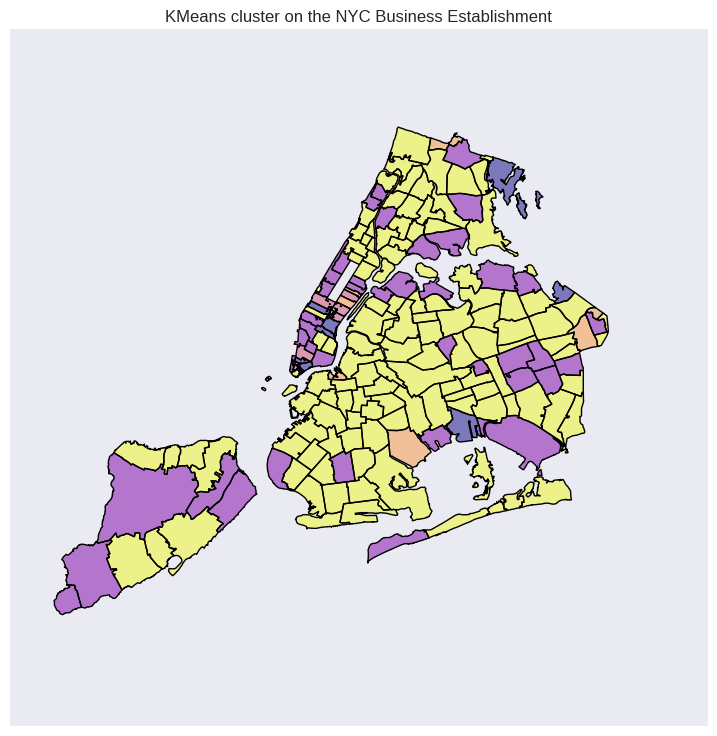

In [33]:
f, ax = plt.subplots(figsize = (9,9))
zipzbp.plot(column = "label_x", cmap = "plasma", figsize = (15,10), ax = ax)
ax.set_title("KMeans cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

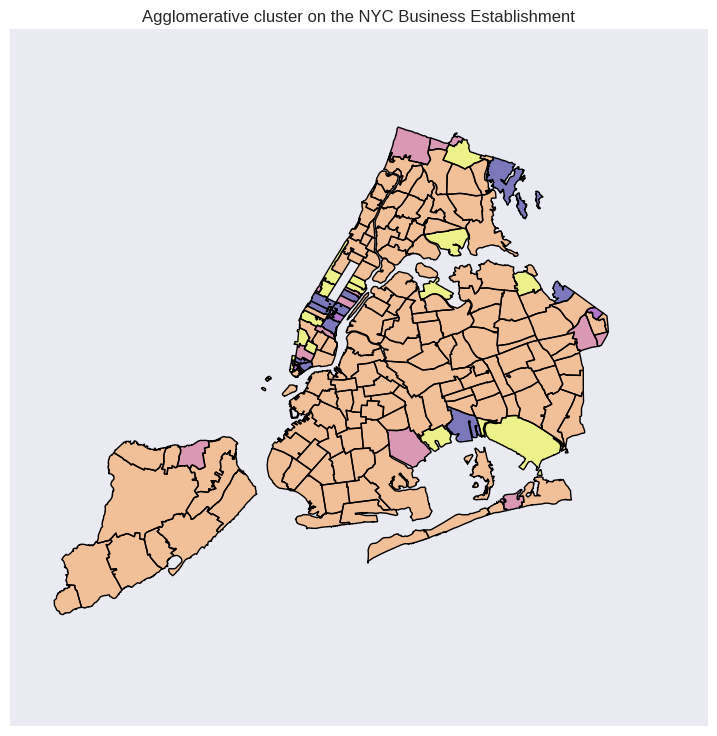

In [34]:
f, ax = plt.subplots(figsize = (9,9))
zipzbp.plot(column = "label_y", cmap = "plasma", figsize = (15,10), ax = ax)
ax.set_title("Agglomerative cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### Compare and Interpretation

I chose 5 clusters and both cluster method result in certain similar pattern. Manhattan itself shows a diversity in the business establishment time.